In [1]:
import pandas as pd
import numpy as np

In [2]:
from itertools import chain
from tqdm.notebook import tqdm

In [3]:
from catboost import CatBoostRanker, Pool, MetricVisualizer
from copy import deepcopy
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, GroupKFold
from typing import Tuple

Первая часть задания, решаем задачу с помощью бустинга.

In [4]:
train = pd.read_csv('./data/train.csv')

In [5]:
# train = train.iloc[:1_000]

In [6]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [7]:
members = pd.read_csv('./data/members.csv')

In [8]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [9]:
songs = pd.read_csv('./data/songs.csv')

In [10]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [11]:
data = train.merge(members).merge(songs)

In [12]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,15,18,male,4,20151220,20170930,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
2,xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1,1,0,NaN,7,20120804,20171004,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
3,s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1,5,21,female,9,20110808,20170917,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
4,Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,0,6,33,female,9,20070323,20170915,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0


In [13]:
mask = ~data.gender.str.contains(r'male', na=False)

data.loc[mask, 'gender'] = pd.Series(['na']*mask.sum(), name='gender', index=mask[mask].index)

In [14]:
data.isna().sum(0)

msno                            0
song_id                         0
source_system_tab           24849
source_screen_name         414796
source_type                 21539
target                          0
city                            0
bd                              0
gender                          0
registered_via                  0
registration_init_time          0
expiration_date                 0
song_length                     0
genre_ids                  118341
artist_name                     0
composer                  1675592
lyricist                  3178684
language                       36
dtype: int64

In [15]:
# точный возраст знать не обязательно -- разделим на условные "поколения"
mask=(data.bd < 10) | (data.bd >= 80)
young = (data.bd >= 10) & (data.bd < 20)
middle = (data.bd >= 20) & (data.bd < 40)
adult = (data.bd >= 40) & (data.bd < 60)
old = (data.bd >= 60) & (data.bd < 80)

data.loc[mask, 'bd'] = 'na'
data.loc[young, 'bd'] = 'young'
data.loc[middle, 'bd'] = 'middle'
data.loc[adult, 'bd'] = 'adult'
data.loc[old, 'bd'] = 'old'

In [16]:
data.loc[data.language==-1, 'language'] = 'na'
data.language = data.language.apply(lambda x: str(x))

In [17]:
data.fillna('na', inplace=True)

In [18]:
class GenresEnconding:
    def __init__(self, bins_number: int):
        self.labels = None
        self.id_to_indx = None
        self.indx_to_id = None
        self.bins_number = bins_number
        self.bins_size = None
    
    def fit(self, X: np.ndarray):
        self.labels = np.unique(list(chain(*[el.split('|') for el in X])))
        self.bins_size = len(self.labels) // self.bins_number + 1
        
        self.id_to_indx = {genre_id: i for i, genre_id in enumerate(self.labels)}
        self.indx_to_id = {i: genre_id for genre_id, i  in self.id_to_indx.items()}
        return self
        
    def transform(self, X: np.ndarray):
        result = np.zeros((len(X), self.bins_number))
        for i, genre_ids in enumerate(tqdm(X)):
            indxs = [self.id_to_indx.get(genre_id, self.id_to_indx['na']) for genre_id in genre_ids.split('|')]
            bin_enc = np.zeros(len(self.labels))
            bin_enc[indxs] = 1
            for b in range(self.bins_number):
                result[i, b] = np.power(2, bin_enc[b*self.bins_size:(b+1)*self.bins_size])[None,:] @ bin_enc[b*self.bins_size:(b+1)*self.bins_size]
        return result
        
    def fit_transform(self, X: np.ndarray):
        return self.fit(X).transform(X)
    

In [19]:
# Вахнот по жанрам добавляет слишком много фичей, так что сгруппируем ванхоты в группы битов и превратим их в десятичное число
ge = GenresEnconding(5)
genres_encodes = ge.fit_transform(data.genre_ids.values)

  0%|          | 0/7377304 [00:00<?, ?it/s]

In [20]:
genres_encodes_df = pd.DataFrame(genres_encodes, columns=[f'genre_bin_{i}' for i in range(ge.bins_number)])

In [21]:
data = pd.concat([data.drop(columns=['genre_ids']), genres_encodes_df], axis=1)

In [22]:
del ge, genres_encodes

In [23]:
data.isna().sum(0)

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
song_length               0
artist_name               0
composer                  0
lyricist                  0
language                  0
genre_bin_0               0
genre_bin_1               0
genre_bin_2               0
genre_bin_3               0
genre_bin_4               0
dtype: int64

In [24]:
data.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length',
       'artist_name', 'composer', 'lyricist', 'language', 'genre_bin_0',
       'genre_bin_1', 'genre_bin_2', 'genre_bin_3', 'genre_bin_4'],
      dtype='object')

In [25]:
data.sort_values("msno", kind="stable", inplace=True)

In [26]:
data = data.groupby('msno').head(1023)

In [27]:
cat_feat_named = ['song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'city', 'bd', 'gender', 'registered_via',
       'artist_name', 'composer', 'lyricist', 'language']

noncat_features = ['song_length', 'genre_bin_0','genre_bin_1', 'genre_bin_2', 'genre_bin_3', 'genre_bin_4']

In [28]:
cat_features = [i for i in range(len(cat_feat_named))]

In [29]:

X = data[cat_feat_named+noncat_features].values
y = data['target'].values
queries = data['msno'].values

In [30]:
def get_split(train_indxs: np.ndarray, test_indxs: np.ndarray)-> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray,np.ndarray,np.ndarray]:
    X_train, X_test = X[train_indxs], X[test_indxs]
    y_train, y_test = y[train_indxs], y[test_indxs]
    queries_train, queries_test = queries[train_indxs], queries[test_indxs]
    
    return X_train, y_train, queries_train, X_test, y_test, queries_test

In [31]:
parameters = {
    'iterations': 2000,
    'custom_metric': ["QueryAUC:type=Ranking"],
    'verbose': False ,
    'random_seed': 0,
    'metric_period': 15, 
    'task_type': 'GPU',
    'loss_function': 'YetiRank',
    'train_dir': 'YetiRank/'
}

In [ ]:
group_kfold = GroupKFold(n_splits=5)
groups = data.msno.to_numpy()
train_index, test_index = next(group_kfold.split(data, groups=groups))
X_train, y_train, queries_train, X_test, y_test, queries_test = get_split(train_index, test_index)

train = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train,
    cat_features=cat_features
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test,
    cat_features=cat_features
)

model = CatBoostRanker(**parameters)
model.fit(train, eval_set=test, plot=True)
score = model.get_evals_result()['validation']['QueryAUC:type=Ranking']
scores.append(score)
del X_train, y_train, queries_train, X_test, y_test, queries_test

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2000 не дает значительного прироста в метриках, а считаются очень уж долго, поэтому сократим до 150

In [31]:
parameters = {
    'iterations': 150,
    'custom_metric': ["QueryAUC:type=Ranking"],
    'verbose': False ,
    'random_seed': 0,
    'metric_period': 15, 
    'task_type': 'GPU',
    'loss_function': 'YetiRank',
    'train_dir': 'YetiRank/'
}

In [32]:
group_kfold = GroupKFold(n_splits=5)
groups = data.msno.to_numpy()

scores = []
for train_index, test_index in group_kfold.split(data, groups=groups):
    X_train, y_train, queries_train, X_test, y_test, queries_test = get_split(train_index, test_index)
    
    train = Pool(
        data=X_train,
        label=y_train,
        group_id=queries_train,
        cat_features=cat_features
    )

    test = Pool(
        data=X_test,
        label=y_test,
        group_id=queries_test,
        cat_features=cat_features
    )
    
    model = CatBoostRanker(**parameters)
    model.fit(train, eval_set=test, plot=False)
    score = model.get_evals_result()['validation']['QueryAUC:type=Ranking']
    scores.append(score)
    del X_train, y_train, queries_train, X_test, y_test, queries_test

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly

In [33]:
scores

[[0.5395937662969412,
  0.5416825526559053,
  0.5429831410362195,
  0.5432705409754547,
  0.5440281762122128,
  0.547270937300478,
  0.5497825565666373,
  0.55139119006369,
  0.5517450789508074,
  0.5555439686724665,
  0.5571431358724092],
 [0.5341704157715326,
  0.5395880157780807,
  0.5397545882282264,
  0.5396852424550643,
  0.540099617565078,
  0.5436172974277356,
  0.5456017024425512,
  0.5463311226050546,
  0.5467203499773065,
  0.5499817885707238,
  0.55321570483938],
 [0.5365527585000958,
  0.5381692343751666,
  0.5406464629987825,
  0.5407948333750858,
  0.5409678816286475,
  0.5459103088400903,
  0.5466870350069141,
  0.5475906841776745,
  0.547424222508015,
  0.5503064786985657,
  0.5528855174321733],
 [0.5330782669595877,
  0.539046315956362,
  0.540867522281051,
  0.5413436068212166,
  0.5410783824348147,
  0.5414027051922259,
  0.5459503600319286,
  0.5467997193521547,
  0.5476885214821965,
  0.5527846556964594,
  0.5540336436871454],
 [0.5316787440926016,
  0.53809934867

In [34]:
aucs = np.vstack([it for it in scores])
mean_auc = aucs.mean(axis=0)
std_auc = aucs.std(axis=0)

In [35]:
x = np.array(range(parameters['iterations']//parameters['metric_period']+1))*parameters['metric_period']

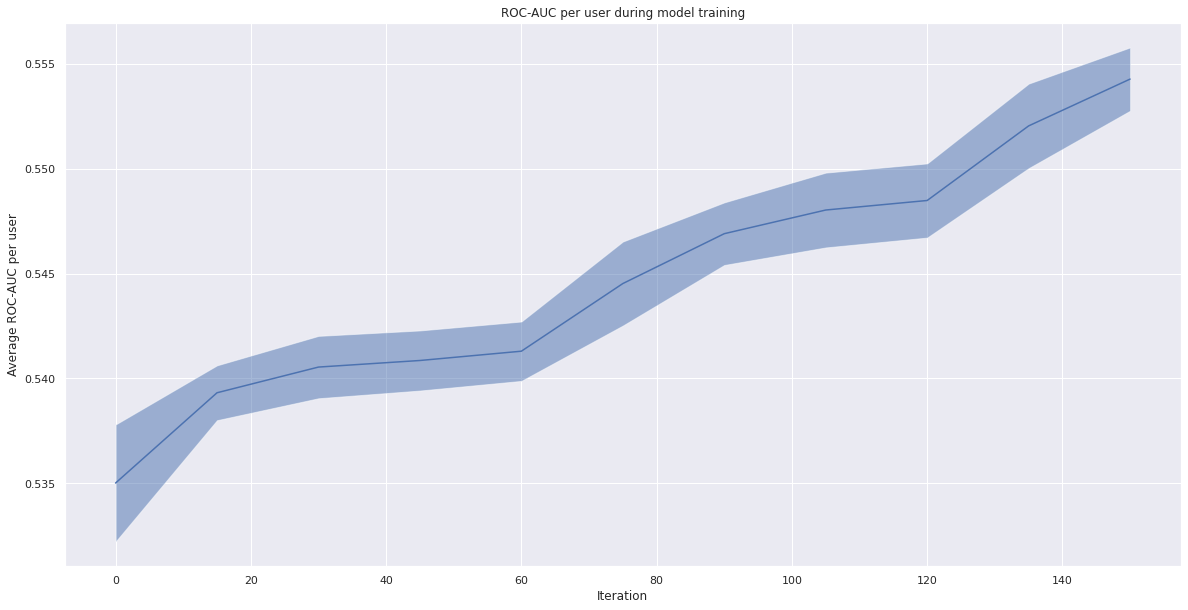

In [36]:
sns.set_theme(rc={"figure.figsize": (20, 10)})
ax = sns.lineplot(x=x, y=mean_auc)
ax.set_title("ROC-AUC per user during model training")
ax.set_ylabel("Average ROC-AUC per user")
ax.set_xlabel("Iteration")
ax.fill_between(x=x, y1 = mean_auc - std_auc, y2 = mean_auc + std_auc, alpha=.5)

In [37]:
mean_auc

array([0.53501479, 0.53931709, 0.54054171, 0.54085498, 0.54129807,
       0.54452163, 0.54689855, 0.54802604, 0.54848034, 0.55203513,
       0.55426636])